<https://colab.research.google.com/drive/1iKsJtRY-7gX_pGAHT2Cu3e75b3LztU63?usp=sharing#scrollTo=AxeTVSj6H1Nz> for <https://towardsdatascience.com/generating-knowledge-graphs-with-wikipedia-ec17030a40f6>

In [1]:
!pip install wikipedia networkx 
!pip install pandas

  Using cached wikipedia-1.4.0.tar.gz (27 kB)
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11696 sha256=1c0b1ad7b9c1bbb84641b37406e303a081ec726b74a4c709df85f54128331c68
  Stored in directory: /Users/wgraham/Library/Caches/pip/wheels/c2/46/f4/caa1bee71096d7b0cdca2f2a2af45cacf35c5760bee8f00948
Successfully built wikipedia


In [2]:
# Data manipulation
import pandas as pd
import random

# Wikipedia API
import wikipedia as wp
from wikipedia.exceptions import DisambiguationError, PageError

# Plotting
import networkx as nx
import matplotlib.pyplot as plt

In [7]:
print(wp.summary('climate change')[:100])

wp.page("climate change").links[:5]



In common usage, climate change describes global warming—the ongoing increase in global average temp


['2011 end times prediction',
 '2012 phenomenon',
 '2019 in climate change',
 '2019–20 Australian bushfire season',
 '2020 in climate change']

In [8]:
class RelationshipGenerator():
    """Generates relationships between terms, based on wikipedia links"""
    def __init__(self):
        """Links are directional, start + end, they should also have a weight"""
        self.links = [] # [start, end, weight]

    def scan(self, start=None, repeat=0):
        """Start scanning from a specific word, or from internal database
        
        Args:
            start (str): the term to start searching from, can be None to let
                algorithm decide where to start
            repeat (int): the number of times to repeat the scan
        """
        while repeat >= 0:

            # should check if start page exists
            # and haven't already scanned
            if start in [l[0] for l in self.links]:
                raise Exception("Already scanned")

            term_search = True if start is not None else False

            # If a start isn't defined, we should find one
            if start is None: 
                start = self.find_starting_point()

            # Scan the starting point specified for links
            print(f"Scanning page {start}...")
            try:
                # Fetch the page through the Wikipedia API
                page = wp.page(start)
                links = list(set(page.links))
                # ignore some uninteresting terms
                links = [l for l in links if not self.ignore_term(l)]

                # Add links to database
                link_weights = []
                for link in links:
                    weight = self.weight_link(page, link)
                    link_weights.append(weight)
                
                link_weights = [w / max(link_weights) for w in link_weights]

                for i, link in enumerate(links):
                    self.links.append([start, link.lower(), link_weights[i] + 2 * int(term_search)]) # 3 works pretty well

                # Print some data to the user on progress
                explored_nodes = set([l[0] for l in self.links])
                explored_nodes_count = len(explored_nodes)
                total_nodes = set([l[1] for l in self.links])
                total_nodes_count = len(total_nodes)
                new_nodes = [l.lower() for l in links if l not in total_nodes]
                new_nodes_count = len(new_nodes)
                print(f"New nodes added: {new_nodes_count}, Total Nodes: {total_nodes_count}, Explored Nodes: {explored_nodes_count}")

            except (DisambiguationError, PageError):
                # This happens if the page has disambiguation or doesn't exist
                # We just ignore the page for now, could improve this
                self.links.append([start, "DISAMBIGUATION", 0])

            repeat -= 1
            start = None
        
    def find_starting_point(self):
        """Find the best place to start when no input is given"""
        # Need some links to work with.
        if len(self.links) == 0:
            raise Exception("Unable to start, no start defined or existing links")
                
        # Get top terms
        res = self.rank_terms()
        sorted_links = list(zip(res.index, res.values))
        all_starts = set([l[0] for l in self.links])

        # Remove identifiers (these are on many Wikipedia pages)
        all_starts = [l for l in all_starts if '(identifier)' not in l]
        
        # print(sorted_links[:10])
        # Iterate over the top links, until we find a new one
        for i in range(len(sorted_links)):
            if sorted_links[i][0] not in all_starts and len(sorted_links[i][0]) > 0:
                return sorted_links[i][0]
        
        # no link found
        raise Exception("No starting point found within links")
        return

    @staticmethod
    def weight_link(page, link):
        """Weight an outgoing link for a given source page
        
        Args:
            page (obj): 
            link (str): the outgoing link of interest
        
        Returns:
            (float): the weight, between 0 and 1
        """
        weight = 0.1
        
        link_counts = page.content.lower().count(link.lower())
        weight += link_counts
        
        if link.lower() in page.summary.lower():
            weight += 3
        
        return weight


    def get_database(self):
        return sorted(self.links, key=lambda x: -x[2])


    def rank_terms(self, with_start=False):
        # We can use graph theory here!
        # tws = [l[1:] for l in self.links]
        df = pd.DataFrame(self.links, columns=["start", "end", "weight"])
        
        if with_start:
            df = df.append(df.rename(columns={"end": "start", "start":"end"}))
        
        return df.groupby("end").weight.sum().sort_values(ascending=False)
    
    def get_key_terms(self, n=20):
        return "'" + "', '".join([t for t in self.rank_terms().head(n).index.tolist() if "(identifier)" not in t]) + "'"

    @staticmethod
    def ignore_term(term):
        """List of terms to ignore"""
        if "(identifier)" in term or term == "doi":
            return True
        return False

In [9]:
def simplify_graph(rg, max_nodes=1000):
    """Simplify a graph which has many nodes
    
    Remove items with low total weights
    This is an alterantive to restricted_view in networkx.
    
    Args:
        rg (RelationshipGenerator): object containing knowledge graph
        max_nodes (float): the number of nodes to search, or percentage of nodes
            to keep
    
    Returns:
        (RelationshipGenerator): simplified knowledge graph
    """
    # Get most interesting terms.
    nodes = rg.rank_terms()

    # Get nodes to keep
    if max_nodes >= 1:
        keep_nodes = nodes.head(max_nodes).index.tolist()
    elif max_nodes >= 0:
        keep_nodes = nodes.head(int(max_nodes * len(nodes))).index.tolist()
    
    # Filter list of nodes so that there are no nodes outside those of interest
    filtered_links = list(filter(lambda x: x[1] in keep_nodes, rg.links))
    filtered_links = list(filter(lambda x: x[0] in keep_nodes, filtered_links))

    # Define a new object and define its dictionary
    ac = RelationshipGenerator()
    ac.links = filtered_links

    return ac

In [10]:
rg = RelationshipGenerator()
rg.scan("climate change")
rg.scan("data analysis")
rg.scan("artificial intelligence")
rg.scan("machine learning")

Scanning page climate change...
New nodes added: 999, Total Nodes: 1006, Explored Nodes: 1
Scanning page data analysis...
New nodes added: 262, Total Nodes: 1266, Explored Nodes: 2
Scanning page artificial intelligence...
New nodes added: 1373, Total Nodes: 2609, Explored Nodes: 3
Scanning page machine learning...


In [12]:
rg.scan(repeat=10)

Scanning page statistics...
New nodes added: 741, Total Nodes: 3224, Explored Nodes: 5
Scanning page fact...
New nodes added: 210, Total Nodes: 3425, Explored Nodes: 6
Scanning page data mining...
Scanning page standard deviation...
Scanning page ai winter...
New nodes added: 302, Total Nodes: 3630, Explored Nodes: 9
Scanning page database...
New nodes added: 646, Total Nodes: 4094, Explored Nodes: 10
Scanning page data...


/opt/homebrew/anaconda3/lib/python3.9/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /opt/homebrew/anaconda3/lib/python3.9/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


Scanning page scientific american...
New nodes added: 188, Total Nodes: 4276, Explored Nodes: 12
Scanning page regression analysis...
New nodes added: 810, Total Nodes: 4609, Explored Nodes: 13
Scanning page misinformation...
New nodes added: 291, Total Nodes: 4880, Explored Nodes: 14
Scanning page the new york times...


In [13]:
print(f"The graph has {rg.rank_terms().shape[0]} terms and {len(rg.links)} connections.\n\n")

rg.rank_terms().head(10)

The graph has 4880 terms and 5840 connections.




end
data                   4.449261
machine learning       4.423015
statistics             4.154893
fact                   4.102224
database               4.098143
data mining            4.095843
scientific american    4.055872
standard deviation     4.050914
ai winter              4.044329
regression analysis    4.028648
Name: weight, dtype: float64

In [16]:
def remove_self_references(l):
    return [i for i in l if i[0]!=i[1]]

def add_focus_point(links, focus="on me", focus_factor=3):
    for i, link in enumerate(links):
        if not (focus in link[0] or focus in link[1]):
            links[i] = [link[0], link[1], link[2] / focus_factor]
        else:
            links[i] = [link[0], link[1], link[2] * focus_factor]

    return links

def create_graph(rg, focus=None):

    links = rg.links
    links = remove_self_references(links)
    if focus is not None:
        links = add_focus_point(links, focus)
    
    node_data = rg.rank_terms()
    nodes = node_data.index.tolist()
    node_weights = node_data.values.tolist()
    node_weights = [nw * 100 for nw in node_weights]
    nodelist = nodes


    G = nx.DiGraph() # MultiGraph()
 
    # G.add_node()
    G.add_nodes_from(nodes)

    # Add edges
    G.add_weighted_edges_from(links)
   
    pos = nx.spring_layout(G, k=1, seed=7)  # positions for all nodes - seed for reproducibility

    fig = plt.figure(figsize=(12,12))

    nx.draw_networkx_nodes(
        G, pos,
        nodelist=nodelist,
        node_size=node_weights,
        node_color='lightblue',
        alpha=0.7
    )

    widths = nx.get_edge_attributes(G, 'weight')    
    nx.draw_networkx_edges(
        G, pos,
        edgelist = widths.keys(),
        width=list(widths.values()),
        edge_color='lightblue',
        alpha=0.6
    )

    nx.draw_networkx_labels(G, pos=pos,
                            labels=dict(zip(nodelist,nodelist)),
                            font_color='black')

    """nx.draw(
        G,
        nodelist=nodes,
        node_size=node_weights,
        with_labels=True,
    )
"""
    # plt.box(False)
    plt.show()

# create_graph(ng)

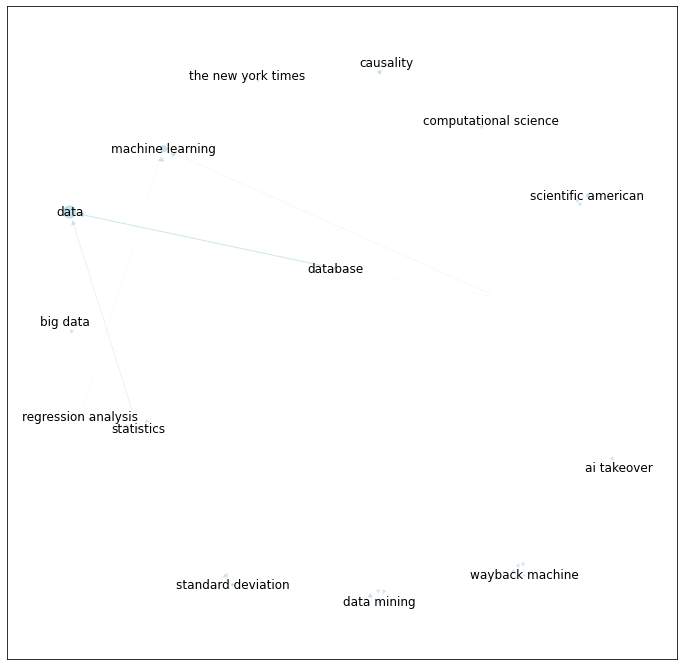

In [17]:
ng = simplify_graph(rg, 20)
create_graph(ng)

In [18]:
def simplified_plot(topics=["tests"], depth=20, max_size=20):

    rg = RelationshipGenerator()
    
    for topic in topics:
        rg.scan(topic)

    rg.scan(repeat=depth)

    print(f"Created {len(rg.links)} links with {rg.rank_terms().shape[0]} nodes.")

    ng = simplify_graph(rg, max_size)

    fig = create_graph(ng)

    plt.show()

    return rg

Scanning page climate change...
New nodes added: 999, Total Nodes: 1006, Explored Nodes: 1
Scanning page artificial intelligence...
New nodes added: 1373, Total Nodes: 2363, Explored Nodes: 2
Scanning page machine learning...
Scanning page ai winter...
New nodes added: 302, Total Nodes: 2570, Explored Nodes: 4
Scanning page scientific american...
New nodes added: 188, Total Nodes: 2753, Explored Nodes: 5
Scanning page misinformation...
New nodes added: 291, Total Nodes: 3029, Explored Nodes: 6
Scanning page the new york times...
Scanning page synthetic intelligence...
New nodes added: 816, Total Nodes: 3048, Explored Nodes: 8
Scanning page intelligence...
New nodes added: 271, Total Nodes: 3190, Explored Nodes: 9
Scanning page transhumanism...
Scanning page technological singularity...
New nodes added: 526, Total Nodes: 3364, Explored Nodes: 11
Scanning page moore's law...
Scanning page future of life institute...
New nodes added: 408, Total Nodes: 3471, Explored Nodes: 13
Scanning pag

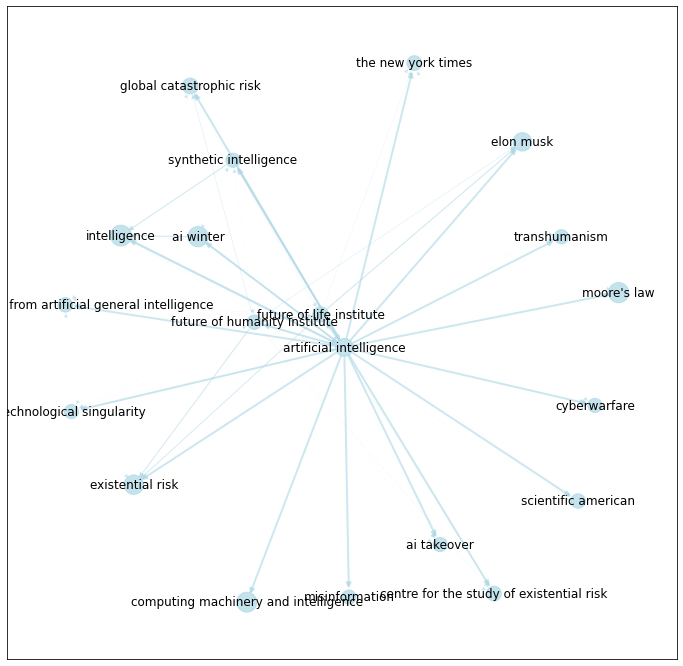

In [20]:
tg = simplified_plot(topics=["climate change", "artificial intelligence", "machine learning"], depth=10)